# MicroNN

A minimal neural network implementation from scratch in NumPy that learns to classify handwritten digits using forward propagation, backpropagation, and gradient descent.

### [dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

License: MIT

## Neural Network

In [1]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
class MicroNN:
    """A minimal 2-layer neural network for digit classification.

    Parameters
    ----------
    input_size : int
        Number of input features (default: 784 for 28x28 images).
    hidden_size : int
        Number of neurons in the hidden layer (default: 10).
    output_size : int
        Number of output classes (default: 10 for digits 0-9).

    Shapes
    ------
    - Input: (input_size, num_samples)
    - Output: (output_size, num_samples)

    Notes
    -----
    - Uses ReLU activation for hidden layer and softmax for output.
    - Weights initialized uniformly in range [-0.5, 0.5].
    - Trained using vanilla gradient descent.
    """

    def __init__(self, input_size: int = 784, hidden_size: int = 10, output_size: int = 10):
        # Store layer sizes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Initialize weights and biases for hidden layer
        self.w1 = np.random.rand(hidden_size, input_size) - 0.5
        self.b1 = np.random.rand(hidden_size, 1) - 0.5
        # Initialize weights and biases for output layer
        self.w2 = np.random.rand(output_size, hidden_size) - 0.5
        self.b2 = np.random.rand(output_size, 1) - 0.5
        # Cached activations for backpropagation
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform forward propagation through the network.

        Parameters
        ----------
        x : np.ndarray
            Input features of shape (input_size, num_samples).

        Returns
        -------
        np.ndarray
            Output probabilities of shape (output_size, num_samples).

        Notes
        -----
        - Caches intermediate values (z1, a1, z2, a2) for backpropagation.
        """
        # Hidden layer: linear + ReLU
        self.z1 = self.w1.dot(x) + self.b1
        self.a1 = self.relu(self.z1)
        # Output layer: linear + softmax
        self.z2 = self.w2.dot(self.a1) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def relu(self, z: np.ndarray) -> np.ndarray:
        """Apply ReLU activation function element-wise.

        Parameters
        ----------
        z : np.ndarray
            Pre-activation values of any shape.

        Returns
        -------
        np.ndarray
            max(0, z) applied element-wise, same shape as input.
        """
        return np.maximum(z, 0)

    def softmax(self, z: np.ndarray) -> np.ndarray:
        """Apply softmax activation to convert logits to probabilities.

        Parameters
        ----------
        z : np.ndarray
            Logits of shape (num_classes, num_samples).

        Returns
        -------
        np.ndarray
            Probabilities summing to 1 along axis 0, same shape as input.

        Notes
        -----
        - Subtracts max for numerical stability before exponentiating.
        """
        # Shift by max for numerical stability
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def one_hot(self, y: np.ndarray) -> np.ndarray:
        """Convert integer labels to one-hot encoded matrix.

        Parameters
        ----------
        y : np.ndarray
            Integer labels of shape (num_samples,).

        Returns
        -------
        np.ndarray
            One-hot matrix of shape (num_classes, num_samples).
        """
        one_hot_y = np.zeros((self.output_size, y.size))
        one_hot_y[y, np.arange(y.size)] = 1
        return one_hot_y

    def backward(self, x: np.ndarray, y: np.ndarray) -> tuple:
        """Compute gradients via backpropagation.

        Parameters
        ----------
        x : np.ndarray
            Input features of shape (input_size, num_samples).
        y : np.ndarray
            Integer labels of shape (num_samples,).

        Returns
        -------
        tuple
            (dw1, db1, dw2, db2) gradients for weights and biases.

        Notes
        -----
        - Uses cross-entropy loss with softmax output.
        - Gradients averaged over batch size.
        """
        m = y.size
        # Convert labels to one-hot
        one_hot_y = self.one_hot(y)
        # Output layer gradients
        dz2 = self.a2 - one_hot_y
        dw2 = (1 / m) * dz2.dot(self.a1.T)
        db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
        # Hidden layer gradients
        dz1 = self.w2.T.dot(dz2) * self.relu_derivative(self.z1)
        dw1 = (1 / m) * dz1.dot(x.T)
        db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
        return dw1, db1, dw2, db2

    def relu_derivative(self, z: np.ndarray) -> np.ndarray:
        """Compute derivative of ReLU activation.

        Parameters
        ----------
        z : np.ndarray
            Pre-activation values of any shape.

        Returns
        -------
        np.ndarray
            1 where z > 0, else 0, same shape as input.
        """
        return (z > 0).astype(float)

    def update(self, grads: tuple, lr: float):
        """Update weights and biases using gradient descent.

        Parameters
        ----------
        grads : tuple
            (dw1, db1, dw2, db2) gradients from backward pass.
        lr : float
            Learning rate (step size for gradient descent).

        Notes
        -----
        - Applies: weight = weight - lr * gradient
        """
        dw1, db1, dw2, db2 = grads
        # Update hidden layer parameters
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        # Update output layer parameters
        self.w2 -= lr * dw2
        self.b2 -= lr * db2

    def train(self, x: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 1000, print_every: int = 20):
        """Train the network using gradient descent.

        Parameters
        ----------
        x : np.ndarray
            Training features of shape (input_size, num_samples).
        y : np.ndarray
            Training labels of shape (num_samples,).
        lr : float
            Learning rate (default: 0.1).
        epochs : int
            Number of training iterations (default: 1000).
        print_every : int
            Print progress every N epochs (default: 20).

        Notes
        -----
        - Performs full-batch gradient descent.
        - Prints training accuracy at specified intervals.
        """
        for epoch in range(epochs):
            # Forward pass
            self.forward(x)
            # Backward pass
            grads = self.backward(x, y)
            # Update parameters
            self.update(grads, lr)
            # Print progress
            if epoch % print_every == 0:
                preds = self.predict(x)
                acc = self.accuracy(preds, y)
                print(f"Epoch {epoch:4d} | Accuracy: {acc:.4f}")

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Predict class labels for input samples.

        Parameters
        ----------
        x : np.ndarray
            Input features of shape (input_size, num_samples).

        Returns
        -------
        np.ndarray
            Predicted labels of shape (num_samples,).
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=0)

    def accuracy(self, preds: np.ndarray, y: np.ndarray) -> float:
        """Calculate classification accuracy.

        Parameters
        ----------
        preds : np.ndarray
            Predicted labels of shape (num_samples,).
        y : np.ndarray
            True labels of shape (num_samples,).

        Returns
        -------
        float
            Fraction of correct predictions (0.0 to 1.0).
        """
        return np.sum(preds == y) / y.size

In [4]:
def load_data(path: str, train_split: float = 0.8):
    """Load and prepare MNIST data for training.

    Parameters
    ----------
    path : str
        Path to the CSV file containing MNIST data.
    train_split : float
        Fraction of data to use for training (default: 0.8).

    Returns
    -------
    x_train : np.ndarray
        Training features of shape (784, num_train_samples).
    y_train : np.ndarray
        Training labels of shape (num_train_samples,).
    x_val : np.ndarray
        Validation features of shape (784, num_val_samples).
    y_val : np.ndarray
        Validation labels of shape (num_val_samples,).

    Notes
    -----
    - Shuffles data before splitting.
    - Normalizes pixel values to [0, 1] range.
    - Transposes features so samples are columns.
    """
    # Load CSV data
    data = np.array(pd.read_csv(path))
    n = len(data)
    # Shuffle data
    np.random.shuffle(data)
    # Split into train and validation
    split_idx = int(train_split * n)
    train_data = data[:split_idx, :]
    val_data = data[split_idx:, :]
    # Extract features and labels (first column is label)
    x_train = train_data[:, 1:].T / 255.0
    y_train = train_data[:, 0]
    x_val = val_data[:, 1:].T / 255.0
    y_val = val_data[:, 0]
    return x_train, y_train, x_val, y_val

## Train

In [5]:
# =============================================================================
# LOAD DATA
# =============================================================================
x_train, y_train, x_val, y_val = load_data("mnist_train.csv")
print(f"Training samples: {y_train.size}")
print(f"Validation samples: {y_val.size}")

# =============================================================================
# CREATE AND TRAIN MODEL
# =============================================================================
model = MicroNN(input_size=784, hidden_size=10, output_size=10)
model.train(x_train, y_train, lr=0.1, epochs=500, print_every=50)

# =============================================================================
# EVALUATE ON VALIDATION SET
# =============================================================================
val_preds = model.predict(x_val)
val_acc = model.accuracy(val_preds, y_val)
print(f"\nValidation Accuracy: {val_acc:.4f}")

Training samples: 48000
Validation samples: 12000
Epoch    0 | Accuracy: 0.1441
Epoch   50 | Accuracy: 0.5475
Epoch  100 | Accuracy: 0.6928
Epoch  150 | Accuracy: 0.7504
Epoch  200 | Accuracy: 0.7846
Epoch  250 | Accuracy: 0.8068
Epoch  300 | Accuracy: 0.8216
Epoch  350 | Accuracy: 0.8333
Epoch  400 | Accuracy: 0.8429
Epoch  450 | Accuracy: 0.8503

Validation Accuracy: 0.8530


Predicted: 2 | Actual: 2


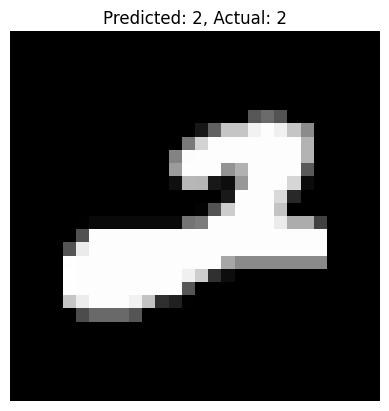

In [6]:
# =============================================================================
# TEST SINGLE PREDICTION
# =============================================================================
sample_idx = 42
pred = model.predict(x_val[:, sample_idx, None])[0]
actual = y_val[sample_idx]
print(f"Predicted: {pred} | Actual: {actual}")

# Display image
plt.imshow(x_val[:, sample_idx].reshape(28, 28), cmap="gray")
plt.title(f"Predicted: {pred}, Actual: {actual}")
plt.axis("off")
plt.show()